## Smoothing options

Looking at the Free State as a whole

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter

In [2]:
data = pd.read_pickle("../rates_and_clusters/ratesClusters_filled_days.pkl")
#data = data[['cluster', 'AllDates', 'INCONCLUSIVE', 'NEGATIVE', 'POSITIVE']]
fsDf = data.groupby('AllDates')[['INCONCLUSIVE', 'NEGATIVE', 'POSITIVE', 'Total']].sum()
fsDf['rate'] = fsDf['POSITIVE'] / fsDf['Total'] *100
fsDf.fillna(0, inplace=True)# Fillna, this is for deviding by zero
fsDf.reset_index(inplace=True)

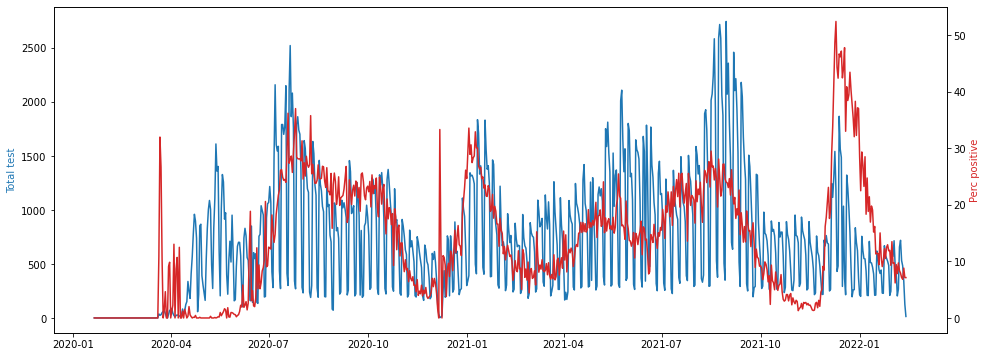

In [3]:

fig, ax1 = plt.subplots(figsize=(16,6))
ax1.plot(fsDf['AllDates'], fsDf['Total'], 'tab:blue')
ax1.set_ylabel('Total test', color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(fsDf['AllDates'], fsDf['rate'], 'tab:red')
ax2.set_ylabel('Perc positive', color='tab:red')
plt.show()

### Savitzky–Golay smoothing

In [4]:
rates = fsDf['rate'].values


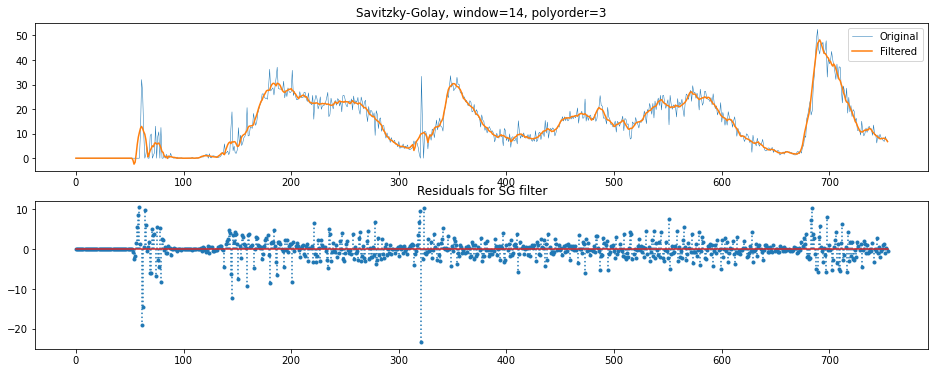

In [5]:
def sg_filter(x, window, polyorder):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(16,6))
    rateSg = savgol_filter(x, window, polyorder)
    resids = (rateSg - rates)
    
    ax1.plot(rates, lw=0.5, label='Original')
    ax1.plot(rateSg, label='Filtered')
    ax1.set_title(f'Savitzky-Golay, window={window}, polyorder={polyorder}')
    ax1.legend()
    
    ax2.stem(np.arange(0,len(rates)), resids, linefmt=':', markerfmt='.')
    #ax2.hlines(y=0, xmin=0, xmax=780, color='gray', lw=1)
    ax2.set_title('Residuals for SG filter')
    
    return [rateSg, resids]

sg_filt = sg_filter(rates, 14, 3)

### FFT smoothing

In [6]:
from scipy.fft import rfft, rfftfreq, irfft

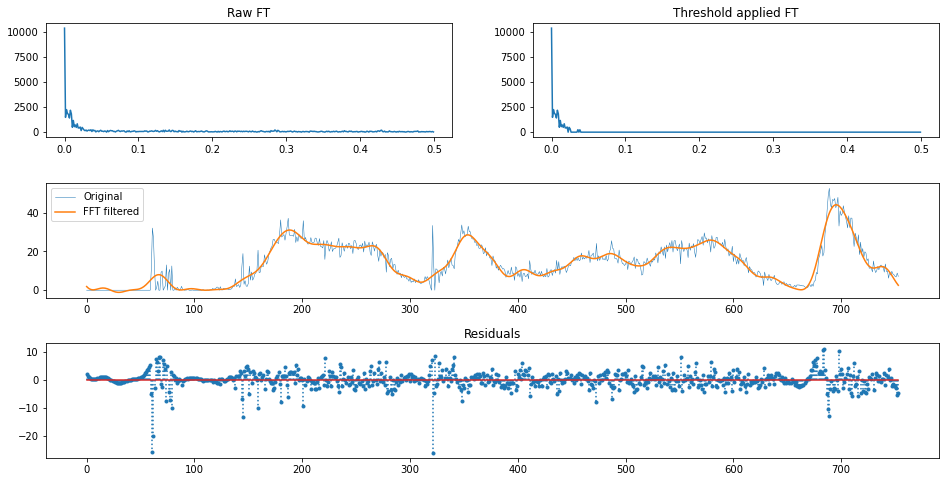

In [8]:
def ft_filter(signal, thres):
    n    = len(signal)
    yf   = rfft(signal)
    xf   = rfftfreq(n,1)
    
    yf_abs = abs(yf)
    indices = (yf_abs>thres) # filter anything with a value/amplitude under specified
    yf_clean = indices * yf # anything below 300 is set to zero
    nFreqs = indices.sum()
    new_f_clean = irfft(yf_clean)
    
    plt.figure(figsize=(16,8))
    
    grid = plt.GridSpec(3, 2, wspace=0.2, hspace=0.4)
    
    plt.subplot(grid[0,0])
    plt.plot(xf,np.abs(yf))
    plt.title('Raw FT')    
    
    plt.subplot(grid[0,1])
    plt.plot(xf, abs(yf_clean))
    plt.title('Threshold applied FT')
    
    
    plt.subplot(grid[1,0:])
    plt.plot(np.arange(n-1), signal[:-1], label='Original', lw=0.5)
    plt.plot(np.arange(n-1), new_f_clean, label='FFT filtered')
    plt.legend()
    
    plt.subplot(grid[2,0:])
    resids = new_f_clean - signal[:-1]
    plt.stem(np.arange(0,len(signal)-1), resids, linefmt=':', markerfmt='.')
    plt.title('Residuals')   
    
    return [new_f_clean, resids]
    
fft_filt = ft_filter(rates, 230)   

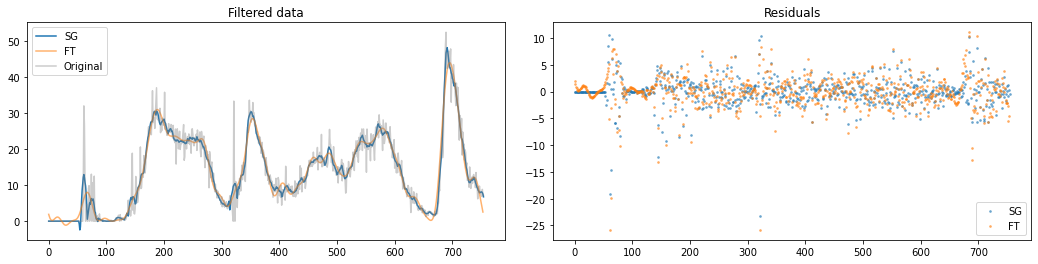

In [9]:
plt.figure(figsize=(18,4))
grid = plt.GridSpec(1,2, wspace=0.1)
plt.subplot(grid[0,0])
plt.plot(sg_filt[0], label='SG')
plt.plot(fft_filt[0], label = 'FT', alpha=0.6)
plt.plot(rates, label='Original', alpha=0.4, color='gray')
plt.legend()
plt.title('Filtered data')
plt.subplot(grid[0,1])
plt.scatter(np.arange(0, len(sg_filt[1])), sg_filt[1], label='SG', s = 3, alpha=0.5)
plt.scatter(np.arange(0, len(fft_filt[1])), fft_filt[1], label = 'FT', s = 3, alpha=0.5)
plt.legend(loc='lower right')
plt.title('Residuals');
